# Train VAE for task2...

Finally trying more silly attempt; no reconstruction loss.

Loss function is now: $loss = 0 L_{Reconstruction} + L_{KLD} = L_{KLD}$

In [1]:
# public modules
from dlcliche.notebook import *
from dlcliche.utils import (
    sys, random, Path, np, plt, EasyDict,
    ensure_folder, deterministic_everything,
)
from argparse import Namespace

# private modules
sys.path.append('..')
import common as com

from pytorch_common import *
from model import VAE, VAE_loss_function

# loading parameters -> hparams (argparse compatible)
params = EasyDict(com.yaml_load('config.yaml'))

# create working directory
ensure_folder(params.model_directory)

# test directories
dirs = com.select_dirs(param=params, mode='development')

# fix random seeds
deterministic_everything(2020, pytorch=True)

# PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2020-03-16 10:46:10,407 - INFO - load_directory <- development


In [2]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6007 (pid 28384), started 1 day, 16:56:35 ago. (Use '!kill 28384' to kill it.)

In [3]:
# VAE Training class

class Task2VAELightning(Task2Lightning):

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat, z, mu, logvar = self.model.forward_all(x)
        loss = VAE_loss_function(recon_x=y_hat, x=x, mu=mu, logvar=logvar,
                                 reconst_loss='mse',
                                 a_RECONST=0., ############# No reconstruction loss
                                 a_KLD=1.)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}


# train models

for target_dir in dirs:
    target = str(target_dir).split('/')[-1]
    print(f'==== Start training [{target}] with {torch.cuda.device_count()} GPU(s). ====')

    files = com.file_list_generator(target_dir)

    model = VAE(device, x_dim=params.VAE.x_dim, h_dim=params.VAE.h_dim, z_dim=params.VAE.z_dim).to(device)
    if target == 'ToyCar': summary(device, model)
    task2 = Task2VAELightning(device, model, params, files, normalize=True)
    trainer = pl.Trainer(max_epochs=10, # params.fit.epochs,  ###### Simple try --> short epochs
                         gpus=torch.cuda.device_count())
    trainer.fit(task2)
    
    model_file = f'{params.model_directory}/model_{target}.pth'
    torch.save(task2.model.state_dict(), model_file)
    print(f'saved {model_file}.\n')

2020-03-16 10:46:20,856 - INFO - target_dir : dev_data/ToyConveyor
2020-03-16 10:46:20,862 - INFO - # of training samples : 3000


==== Start training [ToyConveyor] with 1 GPU(s). ====


2020-03-16 10:46:22,517 - INFO - Loading cached __cache_ToyConveyor_val.npy


2020-03-16 10:46:23,290 - INFO - Loading cached __cache_ToyConveyor_train.npy
2020-03-16 10:46:27,120 - INFO - Loading cached __cache_ToyConveyor_val.npy



saved ./model/model_ToyConveyor.pth.



## Visualize 

2020-03-16 10:50:59,680 - INFO - Loading cached __cache_ToyConveyor_train.npy


(1000, 640) (1000, 640)


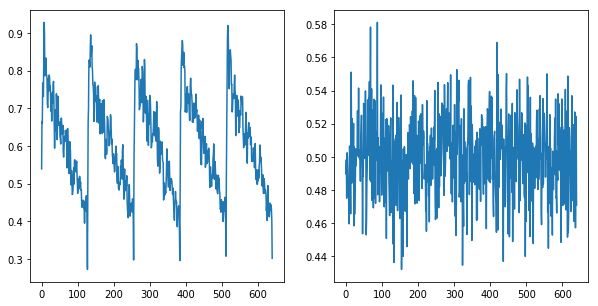

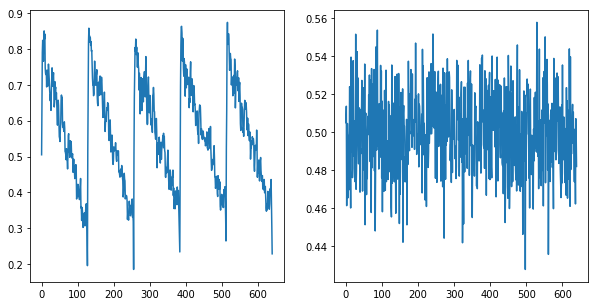

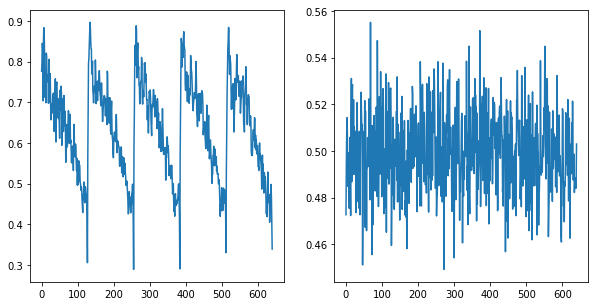

In [4]:
#load_weights(task2.model, 'model/model_ToyCar.pth')
show_some_predictions(task2.train_dataloader(), task2.model, 0, 3)

2020-03-16 10:51:04,124 - INFO - Loading cached __cache_ToyConveyor_val.npy


(1000, 640) (1000, 640)


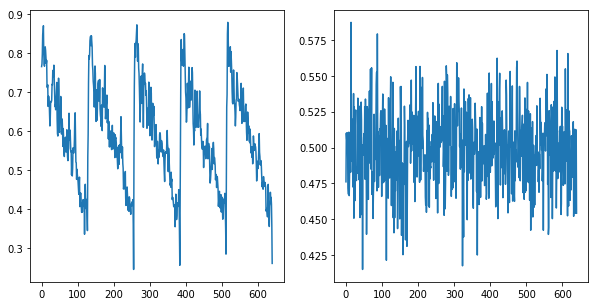

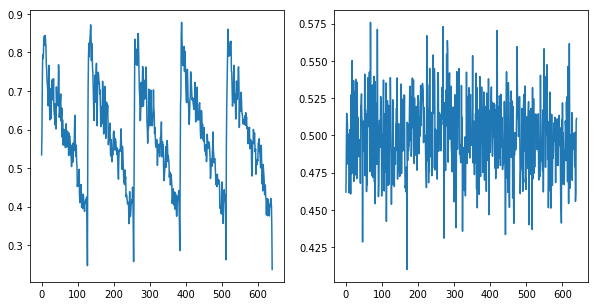

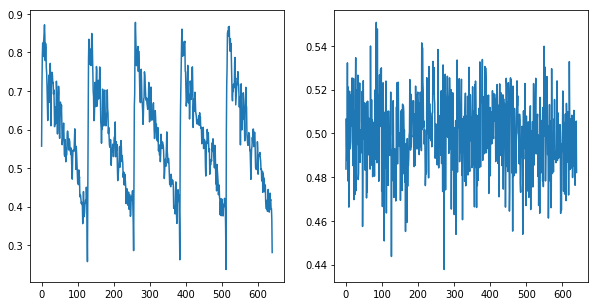

In [5]:
# Validation set samples
show_some_predictions(task2.val_dataloader(), task2.model, 0, 3)

## Check model weights

Maybe nothing meaningful there...

In [7]:
summarize_weights(task2.model)

,mean,std,min,max
fc11.weight,-0.003378,0.022967,-0.067151,0.043466
fc11.bias,-0.003091,0.022291,-0.049707,0.052989
fc12.weight,-0.001311,0.029238,-0.274134,0.090983
fc12.bias,-0.015120,0.028453,-0.158048,0.068429
fc21.weight,-0.001271,0.030028,-0.096968,0.106761
fc21.bias,0.006332,0.012844,-0.017658,0.027103
fc22.weight,-0.000503,0.030847,-0.097039,0.099834
fc22.bias,-0.002460,0.009741,-0.023604,0.016383
fc31.weight,-0.001739,0.129112,-0.223601,0.223503
fc31.bias,-0.004533,0.127499,-0.223236,0.223406


# Test the trained model

In [8]:
! python 01_test.py -d

2020-03-16 10:51:10,420 - INFO - load_directory <- development

[1/1] /home/dl/lab/task2/dcase2020_task2_variants/dev_data/ToyConveyor
============== MODEL LOAD ==============
2020-03-16 10:51:10,420 - INFO - loading model: ./model/model_ToyConveyor.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]         256,400
            Linear-2                  [-1, 400]         160,400
            Linear-3                   [-1, 20]           8,020
            Linear-4                   [-1, 20]           8,020
            Linear-5                  [-1, 400]           8,400
            Linear-6                  [-1, 400]         160,400
            Linear-7                  [-1, 640]         256,640
Total params: 858,280
Trainable params: 858,280
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [9]:
def upto_6digits(cell):
    if not cell[0].isdigit(): return cell
    return f'{float(cell):.6f}'

with open('result/result.csv') as f:
    for l in f.readlines():
        l = l.strip() #replace('\n', '')
        if ',' not in l:
            print(l)
            continue
        ls = l.split(',')
        print(f'{ls[0]}\t\t{upto_6digits(ls[1])}\t\t{upto_6digits(ls[2])}')

ToyConveyor
id		AUC		pAUC
01		0.563631		0.502253
02		0.497792		0.492976
03		0.490039		0.493231
Average		0.517154		0.496153

